# Intermediate Presentation Demo

## 1. Face Embedding

In [1]:
import os
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from dataset.dataset import LFWDataset, download_data
from models.face_net import LightningFaceNet

In [2]:
root = os.path.join('.', 'data', 'lfw_crop')
dataset = LFWDataset(root, transform=transforms.Resize((250, 250)))

iterator = iter(dataset)
label, anchor, positive, negative = next(iterator)

In [3]:
def get_img(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

Aaron_Peirsol


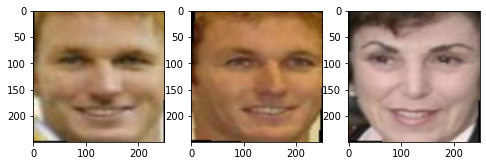

In [4]:
print(label)
fig=plt.figure(figsize=(8, 8))
for i, img in enumerate([anchor, positive, negative]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(get_img(img))

In [5]:
train_length = int(0.8 * len(dataset))
val_length = test_length = (len(dataset) - train_length) // 2

train_set, val_set, test_set = random_split(dataset, [train_length, val_length, test_length])

train_loader = DataLoader(train_set, batch_size=8, num_workers=0)
val_loader = DataLoader(val_set, batch_size=8, num_workers=0)
test_loader = DataLoader(test_set, batch_size=8, num_workers=0)

In [6]:
hparams = {'lr': 0.001, 'margin': 1, 'optimizer': 'Adam'}
model = LightningFaceNet(hparams)

logger = TensorBoardLogger('tb_logs', name='FaceNet on LFW')

trainer = pl.Trainer(gpus=1, max_epochs=190, logger=logger)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_loader, val_loader)


  | Name  | Type    | Params
----------------------------------
0 | model | FaceNet | 40.5 M
----------------------------------
40.5 M    Trainable params
0         Non-trainable params
40.5 M    Total params


In [ ]:
torch.save(model.state_dict(), 'FaceNetOnLFW.pth')

In [ ]:
trainer.test(model, test_loader)

## 2. Face Registration and Recognition

In [ ]:
# imports
import torch.nn.functional as F
import torch
from face_recognition.faceEmbeddingModel import faceEmbeddingModel
from face_recognition.reg_database import RegistrationDatabase
from face_recognition.prep import load_and_transform_img
import sys
import numpy as np

**Use pretrained model**

In [ ]:
embedding_model = faceEmbeddingModel().eval()

In [ ]:
database = RegistrationDatabase()

### Data Augmentation

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

In [ ]:
def load_and_transform_img(path):

    trfrm = transforms.Compose([transforms.Resize(224),  
                           transforms.ToTensor()]) 
                           #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    #prepare preprocess pipeline
    augmentation_1 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.8, contrast=0, saturation=0, hue=0),
        transforms.ToTensor()])   

    augmentation_2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0.8, saturation=0, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
        transforms.ToTensor()]) 
    
    augmentation_5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()])   

    augmentation_6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomPerspective(distortion_scale=0.1, p=1),
        transforms.ToTensor()])  


    # read the image and transform it into tensor then normalize it with our trfrm function pipeline
    reg_img = trfrm(Image.open(path)).unsqueeze(0)

    reg_img_1 = reg_img
    # with newer torchvision version, one can also transform tensor batches (but cannot update torchvision)
    # Thus, I have to convert it to an PIL image first
    reg_img_2 = augmentation_1(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_3 = augmentation_2(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_4 = augmentation_3(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_5 = augmentation_4(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_6 = augmentation_5(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_7 = augmentation_6(reg_img.squeeze(0)).unsqueeze(0)
   

    return reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7

In [ ]:
path = './face_recognition/test_registration_images/Vladimir_01.ppm'
reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(path)

In [ ]:
fig=plt.figure(figsize=(16, 10))

# Normal image
fig.add_subplot(2,4,1)
plt.imshow(reg_img_1[0].permute(1, 2, 0))
plt.title("Normal Image", {'fontsize': 14})

# Random Brightness (between 0.5 and 1.5)
fig.add_subplot(2,4,2)
plt.imshow(reg_img_2[0].permute(1, 2, 0))
plt.title("Random Brightness", {'fontsize': 14})

# Random Contrast (between 0.5 and 1.5)
fig.add_subplot(2,4,3)
plt.imshow(reg_img_3[0].permute(1, 2, 0))
plt.title("Random Contrast", {'fontsize': 14})

# Random Saturation (between 0.5 and 1.5) (Value of how dominant the color is, or how colorful the face looks)
fig.add_subplot(2,4,4)
plt.imshow(reg_img_4[0].permute(1, 2, 0))
plt.title("Random Saturation", {'fontsize': 14})

# Random Hue (between -0.3 and 0.3)
fig.add_subplot(2,4,5)
plt.imshow(reg_img_5[0].permute(1, 2, 0))
plt.title("Random Hue", {'fontsize': 14})

# Horizontal Flip
fig.add_subplot(2,4,6)
plt.imshow(reg_img_6[0].permute(1, 2, 0))
plt.title("Horizontal Flip", {'fontsize': 14})

# Random Perspective
fig.add_subplot(2,4,7)
plt.imshow(reg_img_7[0].permute(1, 2, 0))
plt.title("Random Perspective", {'fontsize': 14})

### Face Registration

In [ ]:
def register_people():

    paths = []
    paths.append('./face_recognition/test_registration_images/Aaron_01.ppm')
    paths.append('./face_recognition/test_registration_images/Abdoulaye_01.ppm')
    paths.append('./face_recognition/test_registration_images/George_01.ppm')
    paths.append('./face_recognition/test_registration_images/Hugo_01.ppm')
    paths.append('./face_recognition/test_registration_images/Ian_01.ppm')
    paths.append('./face_recognition/test_registration_images/Jennifer_01.ppm')
    paths.append('./face_recognition/test_registration_images/Kofi_01.ppm')
    paths.append('./face_recognition/test_registration_images/Lleyton_01.ppm')
    paths.append('./face_recognition/test_registration_images/Vladimir_01.ppm')
    paths.append('./face_recognition/test_registration_images/Yashwant_01.ppm')


    names = []
    names.append('Aaron')
    names.append('Abdoulaye')
    names.append('George')
    names.append('Hugo')
    names.append('Ian')
    names.append('Jennifer')
    names.append('Kofi')
    names.append('Lleyton')
    names.append('Vladimir')
    names.append('Yashwant')


    for i in range(len(names)):
        # data augmentation
        reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(paths[i])
        
        # create embeddings
        img_embedding_tensor_1 = embedding_model(reg_img_1)
        img_embedding_tensor_2 = embedding_model(reg_img_2)
        img_embedding_tensor_3 = embedding_model(reg_img_3)
        img_embedding_tensor_4 = embedding_model(reg_img_4)
        img_embedding_tensor_5 = embedding_model(reg_img_5)
        img_embedding_tensor_6 = embedding_model(reg_img_6)
        img_embedding_tensor_7 = embedding_model(reg_img_7)
        
        # save embeddings to database
        database.face_registration(names[i],img_embedding_tensor_1)
        database.face_registration(names[i],img_embedding_tensor_2)
        database.face_registration(names[i],img_embedding_tensor_3)
        database.face_registration(names[i],img_embedding_tensor_4)
        database.face_registration(names[i],img_embedding_tensor_5)
        database.face_registration(names[i],img_embedding_tensor_6)
        database.face_registration(names[i],img_embedding_tensor_7)

In [ ]:
register_people()

In [ ]:
database.database.head(15)

### Face Recognition

In [ ]:
def face_recognition(path):
    img_1, _, _, _, _, _, _ = load_and_transform_img(path)
    img_embedding_tensor = embedding_model(img_1)
    closest_label, check = database.face_recognition(img_embedding_tensor)
    if check == 'Access':
        print("--- Access --- Recognized person: ", closest_label)
    elif check == 'Decline':
        print("--- Decline ---")

In [ ]:
face_recognition(path)

In [ ]:
from PIL import Image
path = './face_recognition/test_recognition_images/Vladimir_04.ppm'
Image.open(path)

In [ ]:
face_recognition(path)

In [ ]:
path = './face_recognition/test_recognition_images/John_04.ppm'
Image.open(path)

In [ ]:
face_recognition(path)